# Prospecting LA's Backyard Houses with Machine Learning
  
  
## Anupama Garla  


## Price Prediction Final Model + Results Analysis

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

#plotting
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from statistics import mean

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_column', 100)

#get pandas and sql to work together
import psycopg2 as pg
import pandas.io.sql as pd_sql
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

#get distances between coordinates
from geopy.distance import geodesic
import numpy as np

from sklearn.externals import joblib


from Backyard_House_Helper_Functions import geo_data_amenity_count_func, geo_data_dist_func
  

In [12]:
#Connect to sql database
params = {
    'host': 'localhost',  # connecting to _local_ version of psql
    'user': 'agar',
    'dbname': 'properties',    # DB connecting to
    'port': 5432          # port
}

# make connection by unpacking params
connection = pg.connect(**params)

### 3.0 Pull target and features from AirBnB sql table

In [25]:
#Pull target and features from AirBnB sql table
#Get only superhost properties
#Get relevant amenities and location information
#Limit review scores to content-based on property and check-in ease
query_airbnb_edited = """
select cast(regexp_replace(price, '\$|\.00|,', '','g') as int) as price, al.reviews_per_month, al.accommodates, al.bedrooms, al.bathrooms, al.beds, al.availability_365, 
al.review_scores_checkin, al.review_scores_cleanliness, al.review_scores_communication, 
al.review_scores_location, al.review_scores_value, al.property_type, al."latitude", al."longitude", 
regexp_replace(al."neighbourhood", '\ |\-|\/,', '_','g') as "neighborhood",

(count(al."neighbourhood") over
(PARTITION BY al."neighbourhood", al."bedrooms"))
         AS neigh_br_competition,
         
(case when al.amenities like '%Dishwasher%' then 1 else 0 end) as "dishwasher",
(case when al.amenities like '%Garden or backyard%' then 1 else 0 end) as "yard",
(case when al.amenities like '%Patio or balcony%' then 1 else 0 end) as "patio",
(case when al.amenities like '%Self check-in%' then 1 else 0 end) as "check_in_self",
(case when al.amenities like '%parking%' then 1 else 0 end) as "parking",
(case when al.amenities like '%pool%' then 1 else 0 end) as "pool",
(case when al.amenities like '%Long term%' then 1 else 0 end) as "long_term",
(case when al.amenities like '%Baby%' then 1 else 0 end) as "baby",
(case when al.amenities like '%Child%' then 1 else 0 end) as "children",
(case when al.amenities like '%Family%' then 1 else 0 end) as "family",
(case when al.amenities like '%24-hour%' then 1 else 0 end) as "check_in_24hrs",
al."amenities",
(case when al.amenities like '%Washer%' then 1 else 0 end) as "washer_dryer",
(case when al.amenities like '%Air conditioning%' then 1 else 0 end) as "air_con",
(case when al.amenities like '%Heating%' then 1 else 0 end) as "heating",
(case when al.amenities like '%Pets%' then 1 else 0 end) as "pets",
(case when al.amenities like '%Lockbox%' then 1 else 0 end) as "lockbox"

from airbnb_full_listings al
where room_type = 'Entire home/apt' and al.host_is_superhost = 't' and cast(regexp_replace(price, '\$|\.00|,', '','g') as int)<1000 and cast(regexp_replace(price, '\$|\.00|,', '','g') as int)>20
"""

In [207]:
#Pull x target and y features into DataFrame from sql
airbnb_df = pd.read_sql_query(query_airbnb_edited , connection, index_col=None, coerce_float=True, params=None, parse_dates=None, chunksize=None)
airbnb_df.columns

Index(['price', 'reviews_per_month', 'accommodates', 'bedrooms', 'bathrooms',
       'beds', 'availability_365', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'property_type',
       'latitude', 'longitude', 'neighborhood', 'neigh_br_competition',
       'dishwasher', 'yard', 'patio', 'check_in_self', 'parking', 'pool',
       'long_term', 'baby', 'children', 'family', 'check_in_24hrs',
       'washer_dryer', 'air_con', 'heating', 'pets', 'lockbox', 'lat_lon',
       'nearest_sales_price', 'arts_rec_count', 'arts_theater_count',
       'comfort_vs_capacity', 'parks_one_mi', 'parks_four_mi', 'uni_two_mi',
       'transport_airports_ten_mi', 'transport_freeway_two_mi',
       'transport_metro_one_mi', 'transport_metro_two_mi',
       'transport_convenience', 'rarity_per_pricey_hood',
       'longitude_scaled_pos'],
      dtype='object')

In [208]:
#Look at head
airbnb_df.head(20)

,price,reviews_per_month,accommodates,bedrooms,bathrooms,beds,availability_365,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,property_type,latitude,longitude,neighborhood,neigh_br_competition,dishwasher,yard,patio,check_in_self,parking,pool,long_term,baby,children,family,check_in_24hrs,washer_dryer,air_con,heating,pets,lockbox,lat_lon,nearest_sales_price,arts_rec_count,arts_theater_count,comfort_vs_capacity,parks_one_mi,parks_four_mi,uni_two_mi,transport_airports_ten_mi,transport_freeway_two_mi,transport_metro_one_mi,transport_metro_two_mi,transport_convenience,rarity_per_pricey_hood,longitude_scaled_pos
0,90,3.58,2,0.0,1.0,1.0,61,10.0,10.0,10.0,10.0,10.0,Guesthouse,34.08812,-118.13703,Alhambra,2,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,"(34.08812, -118.13703000000001)",567750,4,3,3.500000,5,64,4,1,5,0,1,11,757000.000000,-1.120417
1,80,2.42,5,0.0,1.0,2.0,348,10.0,10.0,10.0,10.0,10.0,Guesthouse,34.08158,-118.13425,Alhambra,2,0,1,0,1,1,0,0,0,0,0,0,0,1,1,1,1,"(34.081579999999995, -118.13425)",567750,4,3,3.200000,2,60,5,1,4,0,0,5,757000.000000,-1.134853
2,299,0.81,4,1.0,1.0,2.0,149,10.0,10.0,10.0,10.0,10.0,Apartment,34.09410,-118.12465,Alhambra,27,1,1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,"(34.0941, -118.12465)",567750,4,3,5.750000,5,66,4,1,6,0,0,7,588026.785714,-1.184702
3,79,2.36,4,1.0,1.0,2.0,33,10.0,10.0,10.0,9.0,10.0,Condominium,34.08664,-118.12315,Alhambra,27,0,0,0,1,1,0,1,1,0,0,0,1,1,1,0,0,"(34.08664, -118.12315)",567750,4,3,5.750000,5,63,4,1,5,0,0,6,588026.785714,-1.192491
4,89,9.66,3,1.0,1.0,2.0,339,10.0,10.0,10.0,10.0,10.0,Condominium,34.07691,-118.12864,Alhambra,27,0,0,1,1,1,0,1,0,0,0,0,1,1,1,0,0,"(34.07691, -118.12863999999999)",567750,3,3,5.833333,4,60,5,1,5,0,0,6,588026.785714,-1.163984
5,108,3.02,6,1.0,1.0,1.0,157,10.0,10.0,10.0,10.0,10.0,Apartment,34.09898,-118.12768,Alhambra,27,0,0,1,1,1,0,1,0,0,0,0,1,1,1,0,0,"(34.09898, -118.12768)",567750,4,3,5.666667,6,67,4,1,5,0,0,6,588026.785714,-1.168969
6,99,2.37,4,1.0,1.0,2.0,126,10.0,10.0,10.0,10.0,9.0,Condominium,34.08524,-118.12256,Alhambra,27,0,0,0,1,1,0,1,0,0,0,0,1,1,1,0,0,"(34.08524, -118.12256000000001)",567750,4,3,5.750000,4,64,4,1,5,0,0,6,588026.785714,-1.195555
7,95,4.41,7,1.0,1.0,4.0,117,10.0,9.0,10.0,10.0,9.0,Condominium,34.09895,-118.12594,Alhambra,27,1,0,0,1,1,0,1,0,0,1,0,1,1,1,0,0,"(34.09895, -118.12593999999999)",567750,4,3,5.642857,4,64,4,1,5,0,0,6,588026.785714,-1.178004
8,75,7.46,3,1.0,1.0,2.0,242,10.0,10.0,10.0,9.0,10.0,House,34.08013,-118.11928,Alhambra,27,0,0,1,1,1,0,0,0,1,0,0,1,1,1,0,0,"(34.08013, -118.11928)",567750,3,3,5.833333,4,54,2,1,5,0,0,6,588026.785714,-1.212587
9,73,6.03,3,1.0,1.0,1.0,3,10.0,10.0,10.0,9.0,9.0,Condominium,34.09559,-118.13504,Alhambra,27,1,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,"(34.09559, -118.13503999999999)",567750,4,3,5.833333,7,68,4,1,6,0,1,12,588026.785714,-1.130751


### 3.1 Setup Pipeline to run Model Iteritively while adding Features

In [241]:
#Create target and feature DataFrames
#Create X target dataframe from 'price'
#Create y feature dataframe from all other columns

X = airbnb_df.iloc[:, 1:]

y = airbnb_df.iloc[:, 0]

#Create lists to store cross-val scores for each metric in a list
# perform train/test split, get dummies for string-type features
X_train, X_test, y_train, y_test = \
    train_test_split(pd.get_dummies(X), y, test_size=0.2, random_state=42)

# Create 5-fold Cross Validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
kf.get_n_splits(X_train)
rmse_list = []
mae_list = []
r2_list = []

#Run model on each kfold split and record scores 
for train_ind, val_ind in kf.split(X_train):
    
    #assign train and validate sets
    X_tr, y_tr = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    
    #fit model
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(X_tr, y_tr)
    
    # score fit model on validation data
    xgb_preds = xgb_model.predict(X_val)
    
    val_score = xgb_model.score(X_val, y_val)
    rmse = np.sqrt(metrics.mean_squared_error(y_val,xgb_preds))
    mae = metrics.mean_absolute_error(y_val, xgb_preds)
    
    r2_list.append(val_score)
    rmse_list.append(rmse)
    mae_list.append(mae)

print("rmse cv avg: ", mean(rmse_list))
print("mae cv avg: ", mean(mae_list))
print("val cv avg: ", mean(r2_list))

/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:28:45] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:31:53] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:34:59] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:38:12] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:41:33] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse cv avg:  84.19835320393335
mae cv avg:  51.38519449371593
val cv avg:  0.6565599023162054


In [338]:
pd.set_option('display.max_column', 10)
X_tr.transpose().head(100)

,7939,100,5769,4814,8195,...,5734,5191,5390,860,7270
reviews_per_month,3.510000e+00,5.300000e-01,8.400000e-01,5.300000e-01,2.680000e+00,...,3.100000e+00,6.000000e-01,0.000000e+00,2.400000e-01,7.710000e+00
accommodates,3.000000e+00,2.000000e+00,4.000000e+00,4.000000e+00,8.000000e+00,...,6.000000e+00,2.000000e+00,4.000000e+00,4.000000e+00,2.000000e+00
bedrooms,1.000000e+00,1.000000e+00,3.000000e+00,2.000000e+00,4.000000e+00,...,2.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00
bathrooms,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.500000e+00,...,2.000000e+00,1.000000e+00,1.000000e+00,2.500000e+00,1.000000e+00
beds,2.000000e+00,1.000000e+00,3.000000e+00,2.000000e+00,5.000000e+00,...,2.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
availability_365,3.100000e+01,2.000000e+00,1.500000e+01,1.170000e+02,1.990000e+02,...,3.300000e+01,2.530000e+02,1.710000e+02,3.390000e+02,1.400000e+01
review_scores_checkin,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,...,1.000000e+01,9.000000e+00,0.000000e+00,1.000000e+01,1.000000e+01
review_scores_cleanliness,1.000000e+01,1.000000e+01,1.000000e+01,9.000000e+00,1.000000e+01,...,9.000000e+00,9.000000e+00,0.000000e+00,9.000000e+00,1.000000e+01
review_scores_communication,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,...,1.000000e+01,9.000000e+00,0.000000e+00,1.000000e+01,1.000000e+01
review_scores_location,1.000000e+01,9.000000e+00,1.000000e+01,1.000000e+01,1.000000e+01,...,1.000000e+01,9.000000e+00,0.000000e+00,9.000000e+00,1.000000e+01


In [339]:
X.columns

Index(['reviews_per_month', 'accommodates', 'bedrooms', 'bathrooms', 'beds',
       'availability_365', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'property_type',
       'latitude', 'longitude', 'neighborhood', 'neigh_br_competition',
       'dishwasher', 'yard', 'patio', 'check_in_self', 'parking', 'pool',
       'long_term', 'baby', 'children', 'family', 'check_in_24hrs',
       'washer_dryer', 'air_con', 'heating', 'pets', 'lockbox', 'lat_lon',
       'nearest_sales_price', 'arts_rec_count', 'arts_theater_count',
       'comfort_vs_capacity', 'parks_one_mi', 'parks_four_mi', 'uni_two_mi',
       'transport_airports_ten_mi', 'transport_freeway_two_mi',
       'transport_metro_one_mi', 'transport_metro_two_mi',
       'transport_convenience', 'rarity_per_pricey_hood',
       'longitude_scaled_pos', 'rarity_property',
       'nearest_sales_price_squared', 'amenities_convenience'],


In [340]:
# Save the model as a pickle in a file 
joblib.dump(xgb_model, 'xgb_model_sun.pkl') 

['xgb_model_sun.pkl']

In [132]:
print(mae_list)

[51.933369971806115, 52.160579128164, 52.00801329152912, 52.853233766085104, 49.19657202208685]


## 3.2 Add Geographic Features

In [74]:
#Import dataset of median sales price per neighborhood
median_prices_df = pd.read_csv("fixed_num_fix - Sheet1.csv")
median_prices_df.head()

,Legend,Neighborho,Geometry,Latitude (generated),Latitude,Longitude (generated),Longitude,Median Sale Price,Median_Price,Number of transactions
0,$10M<,"Malibu Road, Malibu Colony Beach",POLYGON,"34,031,913,681",34.031914,"-118,707,191,786",-118.707192,10650000.0,10650000,8
1,$10M<,Beverly Hills Gateway,POLYGON,"34,092,866,399",34.092866,"-118,410,102,407",-118.410102,10050000.0,10050000,18
2,$5M-$10M,Serra Retreat,POLYGON,"34,041,210,258",34.041210,"-118,679,757,288",-118.679757,5475000.0,5475000,5
3,$5M-$10M,Beverly Hills Flats,POLYGON,"34,078,675,416",34.078675,"-118,412,740,932",-118.412741,7450000.0,7450000,24
4,$5M-$10M,Trousdale,POLYGON,"34,102,484,244",34.102484,"-118,395,982,066",-118.395982,8535000.0,8535000,9


In [89]:
#Reduce Median price df to essential features - location and median price
median_prices_df = median_prices_df.loc[:, ['Latitude',
       'Longitude', 'Median_Price']]
median_prices_df.head()

,Latitude,Longitude,Median_Price
0,34.031914,-118.707192,10650000
1,34.092866,-118.410102,10050000
2,34.041210,-118.679757,5475000
3,34.078675,-118.412741,7450000
4,34.102484,-118.395982,8535000


In [97]:
#Create tuples of latitude and longitude for median prices df and airbnb df, to use with geopy
median_prices_df['lat_lon'] = list(zip(median_prices_df['Latitude'], median_prices_df['Longitude']))
airbnb_df['lat_lon'] = list(zip(airbnb_df['latitude'], airbnb_df['longitude']))

#find nearest median home sales price to airbnb property
geo_data_dist_func(airbnb_df, "nearest_sales_price", median_prices_df, 'Median_Price')

In [106]:
#check most common nearest sales price values
airbnb_df["nearest_sales_price"].value_counts()

1791500     462
567750      432
925000      397
1300000     320
730000      302
907000      222
1550000     187
1425000     183
1186500     181
650000      174
1872500     172
855000      170
1610000     155
679000      147
390000      141
1075000     123
915000      113
1427250     109
1050000     105
610000      101
1160000     101
630000      100
1555000      98
787750       98
2000000      97
931500       96
812500       96
970000       95
1150000      85
833000       83
1280000      82
952000       81
8535000      76
1185000      76
695000       71
965000       71
3869000      70
1792000      65
447500       63
635000       61
680000       60
550000       58
1604500      56
950500       54
800000       50
611000       49
580250       48
1199000      46
500000       44
570000       44
1040000      44
2800000      44
1850000      43
1078500      42
600000       41
2360000      40
700000       39
485000       39
1116250      39
855500       35
1100000      34
385000       33
535000  

In [ ]:
culture_geo_df = pd.read_csv("Cultural_and_Performing_Arts_Centers.csv")
museum_geo_df = pd.read_csv("Museums_and_Aquariums.csv")
parks_geo_df = pd.read_csv("Parks_and_Gardens.csv")
colleges_geo_df = pd.read_csv("Colleges_and_Universities.csv")
airports_geo_df = pd.read_csv("Airports.csv")
transport_freeway_geo_df = pd.read_csv("Freeway_Exits.csv")
transport_metro_geo_df = pd.read_csv("Metro_Stations.csv")
transport_walkability_geo_df = pd.read_csv("Walkability_Index_Score_2012.csv")

geo_data_amenity_count_func(museum_geo_df, 5, "arts_rec_count")
geo_data_amenity_count_func(culture_geo_df, 5, "arts_theater_count")
geo_data_amenity_count_func(parks_geo_df, 1, "parks_one_mi")
geo_data_amenity_count_func(parks_geo_df, 4, "parks_four_mi")
geo_data_amenity_count_func(colleges_geo_df, 2, "uni_two_mi")
geo_data_amenity_count_func(airports_geo_df, 10, "transport_airports_ten_mi")
geo_data_amenity_count_func(transport_freeway_geo_df, 2, "transport_freeway_two_mi")
geo_data_amenity_count_func(transport_metro_geo_df, 1, "transport_metro_one_mi")
geo_data_amenity_count_func(transport_metro_geo_df, 2, "transport_metro_two_mi")

In [124]:
#check most common arts_rec count values
airbnb_df['arts_rec_count'].value_counts()

6     946
1     902
5     751
0     713
7     710
4     679
10    656
8     630
9     499
11    467
12    305
2     255
3     224
13    164
14    151
15    104
16     57
17     18
18      1
Name: arts_rec_count, dtype: int64

In [170]:
#replace incorrect values with 0

airbnb_df = airbnb_df.replace(-np.inf, 0)
airbnb_df = airbnb_df.replace(np.inf, 0)
airbnb_df = airbnb_df.replace(np.nan, 0)
airbnb_df["bedrooms"] = airbnb_df["bedrooms"].replace(np.nan, 0)

In [171]:
#verify types and non-null values removed, df ready for modelling
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8232 entries, 0 to 8231
Data columns (total 46 columns):
price                          8232 non-null int64
reviews_per_month              8232 non-null float64
accommodates                   8232 non-null int64
bedrooms                       8232 non-null float64
bathrooms                      8232 non-null float64
beds                           8232 non-null float64
availability_365               8232 non-null int64
review_scores_checkin          8232 non-null float64
review_scores_cleanliness      8232 non-null float64
review_scores_communication    8232 non-null float64
review_scores_location         8232 non-null float64
review_scores_value            8232 non-null float64
property_type                  8232 non-null object
latitude                       8232 non-null float64
longitude                      8232 non-null float64
neighborhood                   8232 non-null object
neigh_br_competition           8232 non-null int64
di

## 3.3 Feature Engineering

In [140]:
#Create a feature that captures density and favors properties that claimed they could accommodate a lot of people, 
#and actually provided a lot of space for those people in terms of bedrooms and bathrooms.  

airbnb_df['comfort_vs_capacity'] = (airbnb_df['bathrooms']/airbnb_df['accommodates'] + \
                                    airbnb_df['bathrooms']/(airbnb_df['bedrooms']+1) +
                                    (airbnb_df['bedrooms']+1)**2 + airbnb_df['bathrooms']**2)

In [235]:
#run model to see if feature engineering impacted model scores

X = airbnb_df.iloc[:, 1:]

y = airbnb_df.iloc[:, 0]

# perform train/test split
X_train, X_test, y_train, y_test = \
    train_test_split(pd.get_dummies(X), y, test_size=0.2, random_state=42)

kf = KFold(n_splits=5, random_state=42, shuffle=True)
kf.get_n_splits(X_train)

rmse_list = []
mae_list = []
r2_list = []

for train_ind, val_ind in kf.split(X_train):
    
    #assign train and validate sets
    X_tr, y_tr = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    
    #fit model
    dtr_model = DecisionTreeRegressor()
    dtr_model.fit(X_tr, y_tr)
    
    # score fit model on validation data
    val_score = dtr_model.score(X_val, y_val)
    lr_preds = dtr_model.predict(X_val)
    rmse = np.sqrt(metrics.mean_squared_error(y_val,lr_preds))
    mae = metrics.mean_absolute_error(y_val,lr_preds)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(val_score)
    
print("rmse cv avg: ", mean(rmse_list))
print("mae cv avg: ", mean(mae_list))
print("r2 cv avg: ", mean(r2_list))

rmse cv avg:  105.20769944947422
mae cv avg:  62.04813971146545
r2 cv avg:  0.46157035228117255


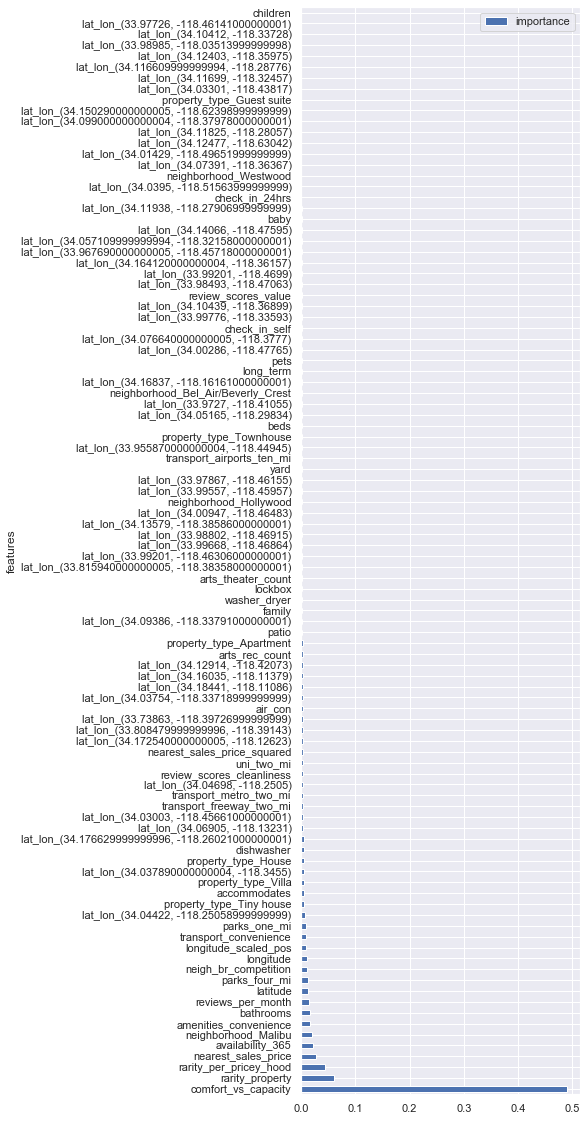

In [236]:
#understand feature importances

col = X_tr.columns
imp = dtr_model.feature_importances_
importance_df = pd.DataFrame()
importance_df["features"] = col
importance_df["importance"] = imp
importance_sorted_df = importance_df.sort_values(by='importance', ascending=False)
importance_sorted_df.head(100).plot.barh(x="features", figsize=(5,20))
plt.savefig("feature_importances_dtr_1.png")

In [232]:
airbnb_df.describe()

,price,reviews_per_month,accommodates,bedrooms,bathrooms,beds,availability_365,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,latitude,longitude,neigh_br_competition,dishwasher,yard,patio,check_in_self,parking,pool,long_term,baby,children,family,check_in_24hrs,washer_dryer,air_con,heating,pets,lockbox,nearest_sales_price,arts_rec_count,arts_theater_count,comfort_vs_capacity,parks_one_mi,parks_four_mi,uni_two_mi,transport_airports_ten_mi,transport_freeway_two_mi,transport_metro_one_mi,transport_metro_two_mi,transport_convenience,rarity_per_pricey_hood,longitude_scaled_pos,rarity_property,nearest_sales_price_squared,amenities_convenience
count,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8.232000e+03,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8.232000e+03,8.232000e+03,8.232000e+03,8.232000e+03,8232.000000
mean,190.893950,2.480810,4.306608,1.532191,1.430940,2.222425,178.203960,9.154519,9.025996,9.159014,9.092809,8.928936,34.042029,-118.337065,62.927478,0.420311,0.440476,0.534257,0.576652,0.944485,0.008382,0.465865,0.060253,0.107264,0.340258,0.135204,0.736880,0.815112,0.959791,0.274417,0.234086,1.192005e+06,6.211249,4.327624,11.451748,4.697643,49.750850,4.053693,3.021866,5.551992,0.568999,1.866011,23.296769,1.293484e+06,-8.170642e-02,2.687577e+06,2.531084e+12,528.545432
std,143.198831,2.201998,2.644307,1.188649,0.769789,1.650620,121.309799,2.704843,2.689325,2.703841,2.693763,2.676532,0.134402,0.155006,68.952005,0.493639,0.496474,0.498855,0.494120,0.228997,0.091174,0.498864,0.237969,0.309468,0.473824,0.341962,0.440353,0.388230,0.196461,0.446247,0.423452,1.053728e+06,4.011156,3.232485,11.417813,3.403037,18.680296,4.042633,1.677354,5.611937,1.169034,2.856024,27.946827,1.150371e+06,8.048936e-01,3.204529e+06,9.021663e+12,333.343746
min,24.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.338830,-118.934220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.338530e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.394172e+05,-3.627687e+00,-4.582117e+05,1.114578e+11,0.000000
25%,100.000000,0.670000,2.000000,1.000000,1.000000,1.000000,67.000000,10.000000,10.000000,10.000000,10.000000,9.000000,33.996700,-118.447188,12.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,6.570000e+05,3.000000,1.000000,5.750000,2.000000,42.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,7.437736e+05,-5.098790e-01,1.064404e+06,4.316490e+11,300.000000
50%,146.000000,2.000000,4.000000,1.000000,1.000000,2.000000,164.000000,10.000000,10.000000,10.000000,10.000000,10.000000,34.060980,-118.352800,35.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,9.250000e+05,6.000000,5.000000,6.000000,4.000000,49.000000,3.000000,3.000000,4.000000,0.000000,0.000000,11.000000,9.863693e+05,-3.689598e-14,1.923867e+06,8.556250e+11,456.000000
75%,225.000000,3.762500,6.000000,2.000000,2.000000,3.000000,300.000000,10.000000,10.000000,10.000000,10.000000,10.000000,34.110445,-118.254607,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.425000e+06,9.000000,7.000000,14.066667,7.000000,63

In [179]:
# engineer feature that favors proximity to metro over proximity to freeway and airport

airbnb_df["transport_convenience"] = airbnb_df["transport_airports_ten_mi"] \
                                    + airbnb_df["transport_metro_one_mi"]*10 + airbnb_df["transport_metro_two_mi"]*5 \
                                    + airbnb_df["parking"]*airbnb_df["transport_freeway_two_mi"]

#drop amenities as this features has many values in string format and the most important ones have been extracted already
airbnb_df = airbnb_df.drop(columns = ['amenities'])

#engineer feature that favors good neighborhoods and less competition
airbnb_df["rarity_per_pricey_hood"] = (airbnb_df["nearest_sales_price"] / (airbnb_df["neigh_br_competition"]+1)) 
                                    + airbnb_df["nearest_sales_price"] 
    
#robust scale and make positive longitudinal feature, so number is comparative and greater when closer to beach
airbnb_df["longitude_scaled_pos"] = RobustScaler().fit_transform(airbnb_df[["longitude"]]*-1)

#engineer feature that favors good neighborhoods and less competition and the beach
airbnb_df["rarity_property"] = (airbnb_df["nearest_sales_price"] / (airbnb_df["neigh_br_competition"]+1)) \
                                + (airbnb_df["nearest_sales_price"]*airbnb_df["longitude_scaled_pos"]) \
                                    + airbnb_df["nearest_sales_price"]*2 

#engineer feature that increases impact of nearest sales price
airbnb_df["nearest_sales_price_squared"] = airbnb_df["nearest_sales_price"]**2

#engineer feature that encapsulates proximity to various cultural and logistical amenities
airbnb_df["amenities_convenience"] = airbnb_df["parks_four_mi"] + airbnb_df["parks_one_mi"]*12*5 + airbnb_df["uni_two_mi"]*10 +\
                        (airbnb_df["parks_four_mi"] + (airbnb_df["arts_theater_count"] + airbnb_df["arts_rec_count"])*4)\
                        *(airbnb_df["parking"]+airbnb_df["transport_metro_one_mi"]) 

### 3.4 Look at top 50 most predictive features

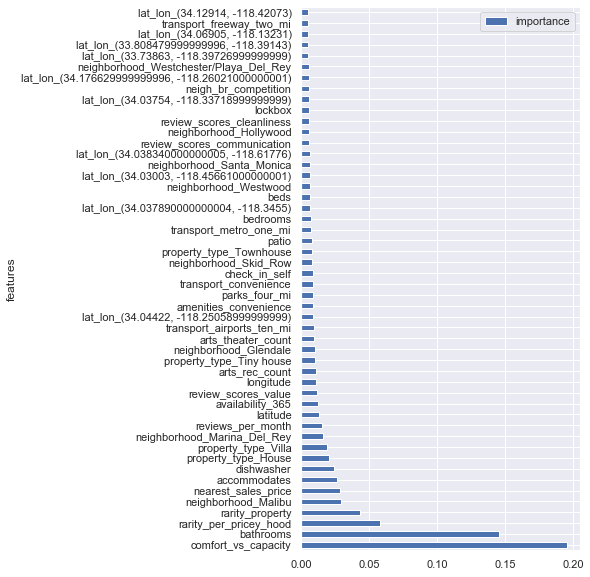

In [276]:
col = X_tr.columns
imp = xgb_model.feature_importances_
importance_df = pd.DataFrame()
importance_df["features"] = col
importance_df["importance"] = imp
importance_sorted_df = importance_df.sort_values(by='importance', ascending=False)
importance_sorted_df.head(50).plot.barh(x="features", figsize=(5,10))
plt.savefig("feature_importances_xgb_weds.svg")

### 3.5 Apply model to test set

In [250]:
#apply model to test set, get scores

xgb_preds = xgb_model.predict(X_test)
    
val_score = xgb_model.score(X_test, y_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test,xgb_preds))
mae = metrics.mean_absolute_error(y_test, xgb_preds)

print("rmse : ", rmse)
print("mae : ", mae)
print("val : ", val_score)

rmse :  83.71381321528965
mae :  50.72617458674715
val :  0.64450619003834


### 3.6 Explore where model failed - look at outliers

In [278]:
airbnb_df_drop_lat_lon = airbnb_df.drop(columns = ["lat_lon"])

In [282]:
X = airbnb_df.iloc[:, 1:]

In [283]:
X.columns

Index(['reviews_per_month', 'accommodates', 'bedrooms', 'bathrooms', 'beds',
       'availability_365', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'property_type',
       'latitude', 'longitude', 'neighborhood', 'neigh_br_competition',
       'dishwasher', 'yard', 'patio', 'check_in_self', 'parking', 'pool',
       'long_term', 'baby', 'children', 'family', 'check_in_24hrs',
       'washer_dryer', 'air_con', 'heating', 'pets', 'lockbox', 'lat_lon',
       'nearest_sales_price', 'arts_rec_count', 'arts_theater_count',
       'comfort_vs_capacity', 'parks_one_mi', 'parks_four_mi', 'uni_two_mi',
       'transport_airports_ten_mi', 'transport_freeway_two_mi',
       'transport_metro_one_mi', 'transport_metro_two_mi',
       'transport_convenience', 'rarity_per_pricey_hood',
       'longitude_scaled_pos', 'rarity_property',
       'nearest_sales_price_squared', 'amenities_convenience'],


In [284]:
#get predictions of test set
#get difference between predicted and actual 

xgb_preds_verify = xgb_model.predict(pd.get_dummies(X))
airbnb_df["xgb_preds"] = xgb_preds_verify
airbnb_df["price_minus_xgb_preds"] = airbnb_df["price"] - airbnb_df["xgb_preds"]
airbnb_df.to_csv("validated_df_sun.csv")

In [287]:
airbnb_df.describe()

,price,reviews_per_month,accommodates,bedrooms,bathrooms,beds,availability_365,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,latitude,longitude,neigh_br_competition,dishwasher,yard,patio,check_in_self,parking,pool,long_term,baby,children,family,check_in_24hrs,washer_dryer,air_con,heating,pets,lockbox,nearest_sales_price,arts_rec_count,arts_theater_count,comfort_vs_capacity,parks_one_mi,parks_four_mi,uni_two_mi,transport_airports_ten_mi,transport_freeway_two_mi,transport_metro_one_mi,transport_metro_two_mi,transport_convenience,rarity_per_pricey_hood,longitude_scaled_pos,rarity_property,nearest_sales_price_squared,amenities_convenience,xgb_preds,price_minus_xgb_preds
count,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8.232000e+03,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8232.000000,8.232000e+03,8.232000e+03,8.232000e+03,8.232000e+03,8232.000000,8232.000000,8232.000000
mean,190.893950,2.480810,4.306608,1.532191,1.430940,2.222425,178.203960,9.154519,9.025996,9.159014,9.092809,8.928936,34.042029,-118.337065,62.927478,0.420311,0.440476,0.534257,0.576652,0.944485,0.008382,0.465865,0.060253,0.107264,0.340258,0.135204,0.736880,0.815112,0.959791,0.274417,0.234086,1.192005e+06,6.211249,4.327624,11.451748,4.697643,49.750850,4.053693,3.021866,5.551992,0.568999,1.866011,23.296769,1.293484e+06,-8.170642e-02,2.687577e+06,2.531084e+12,528.545432,190.676041,0.217928
std,143.198831,2.201998,2.644307,1.188649,0.769789,1.650620,121.309799,2.704843,2.689325,2.703841,2.693763,2.676532,0.134402,0.155006,68.952005,0.493639,0.496474,0.498855,0.494120,0.228997,0.091174,0.498864,0.237969,0.309468,0.473824,0.341962,0.440353,0.388230,0.196461,0.446247,0.423452,1.053728e+06,4.011156,3.232485,11.417813,3.403037,18.680296,4.042633,1.677354,5.611937,1.169034,2.856024,27.946827,1.150371e+06,8.048936e-01,3.204529e+06,9.021663e+12,333.343746,113.751396,76.513239
min,24.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.338830,-118.934220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.338530e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.394172e+05,-3.627687e+00,-4.582117e+05,1.114578e+11,0.000000,73.306633,-403.257874
25%,100.000000,0.670000,2.000000,1.000000,1.000000,1.000000,67.000000,10.000000,10.000000,10.000000,10.000000,9.000000,33.996700,-118.447188,12.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,6.570000e+05,3.000000,1.000000,5.750000,2.000000,42.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,7.437736e+05,-5.098790e-01,1.064404e+06,4.316490e+11,300.000000,118.085491,-35.919403
50%,146.000000,2.000000,4.000000,1.000000,1.000000,2.000000,164.000000,10.000000,10.000000,10.000000,10.000000,10.000000,34.060980,-118.352800,35.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,9.250000e+05,6.000000,5.000000,6.000000,4.000000,49.000000,3.000000,3.000000,4.000000,0.000000,0.000000,11.000000,9.863693e+05,-3.689598e-14,1.923867e+06,8.556250e+11,456.000000,146.601418,-9.804962
75%,225.000000,3.762500,6.000000,2.000000,2.000000,3.000000,300.000000,10.000000,10.000000,10.000000,10.000000,10.000000,34.110445,-118.254607,90.000000,1.000000,1.000000,1.000000,1.00000

In [302]:
#divide dataset based on predictions that were too high, too low, and generally good
mask_too_low_pred = airbnb_df["price_minus_xgb_preds"]>22.272768
mask_too_high_pred = airbnb_df["price_minus_xgb_preds"]<-35.919403
mask_good_pred = (22.272768>airbnb_df["price_minus_xgb_preds"]) & (airbnb_df["price_minus_xgb_preds"]>-35.919403)

too_high_predictions = airbnb_df[mask_too_high_pred]
too_low_predictions = airbnb_df[mask_too_low_pred]
good_predictions = airbnb_df[mask_good_pred]

In [291]:
#look at possible reasons whey these predictions were too low
too_low_predictions.describe()

,price,reviews_per_month,accommodates,bedrooms,bathrooms,beds,availability_365,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,latitude,longitude,neigh_br_competition,dishwasher,yard,patio,check_in_self,parking,pool,long_term,baby,children,family,check_in_24hrs,washer_dryer,air_con,heating,pets,lockbox,nearest_sales_price,arts_rec_count,arts_theater_count,comfort_vs_capacity,parks_one_mi,parks_four_mi,uni_two_mi,transport_airports_ten_mi,transport_freeway_two_mi,transport_metro_one_mi,transport_metro_two_mi,transport_convenience,rarity_per_pricey_hood,longitude_scaled_pos,rarity_property,nearest_sales_price_squared,amenities_convenience,xgb_preds,price_minus_xgb_preds
count,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2.058000e+03,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2.058000e+03,2058.000000,2.058000e+03,2.058000e+03,2058.000000,2058.000000,2058.000000
mean,321.105928,2.053581,4.946550,1.840136,1.617104,2.551506,197.180272,8.792517,8.700680,8.805637,8.780369,8.540330,34.038003,-118.355456,66.677843,0.502915,0.453353,0.574344,0.537415,0.953839,0.016035,0.483965,0.079689,0.140428,0.334305,0.124393,0.823615,0.832362,0.962099,0.321186,0.197279,1.333779e+06,6.298348,4.418367,14.074742,4.851798,47.736152,4.172012,3.009718,5.208941,0.560253,1.776482,22.493683,1.444783e+06,0.013791,3.130105e+06,3.392072e+12,538.607386,230.003616,91.102309
std,193.844189,1.955039,2.988726,1.265143,0.916355,1.930871,123.365211,3.183453,3.152086,3.181914,3.175221,3.126809,0.135613,0.153042,71.795716,0.500113,0.497940,0.494562,0.498719,0.209885,0.125640,0.499864,0.270877,0.347515,0.471862,0.330109,0.381240,0.373636,0.191003,0.467045,0.398041,1.270390e+06,3.917775,3.190651,13.943799,3.635280,18.848728,4.118629,1.636038,5.714575,1.243169,3.078394,30.558331,1.372171e+06,0.794694,3.864405e+06,1.171052e+13,357.943899,139.918045,85.934170
min,110.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.338900,-118.911580,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.338530e+05,0.000000,0.000000,3.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.394172e+05,-3.591339,-3.571457e+05,1.114578e+11,0.000000,73.306633,22.277466
25%,185.000000,0.470000,3.000000,1.000000,1.000000,1.000000,82.000000,10.000000,9.000000,10.000000,10.000000,9.000000,33.997397,-118.462750,13.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,7.300000e+05,4.000000,1.000000,5.833333,2.000000,42.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,8.133333e+05,-0.465495,1.258289e+06,5.329000e+11,296.000000,133.317745,36.899504
50%,250.000000,1.550000,4.000000,2.000000,1.000000,2.000000,205.000000,10.000000,10.000000,10.000000,10.000000,10.000000,34.060820,-118.369585,38.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.050000e+06,6.000000,5.000000,10.533333,4.000000,47.000000,3.000000,3.000000,4.000000,0.000000,0.000000,9.000000,1.095000e+06,0.087159,2.468093e+06,1.102500e+12,454.000000,178.166237,61.287254
75%,395.000000,3.140000,6.000000,2.000000,2.000000,3.000000,317.000000,10.000000,10.000000,10.000000,10.000000,10.000000,34.107633,-118.263155,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000

In [292]:
#look at possible reasons why these predictions were too high
too_high_predictions.describe()

,price,reviews_per_month,accommodates,bedrooms,bathrooms,beds,availability_365,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,latitude,longitude,neigh_br_competition,dishwasher,yard,patio,check_in_self,parking,pool,long_term,baby,children,family,check_in_24hrs,washer_dryer,air_con,heating,pets,lockbox,nearest_sales_price,arts_rec_count,arts_theater_count,comfort_vs_capacity,parks_one_mi,parks_four_mi,uni_two_mi,transport_airports_ten_mi,transport_freeway_two_mi,transport_metro_one_mi,transport_metro_two_mi,transport_convenience,rarity_per_pricey_hood,longitude_scaled_pos,rarity_property,nearest_sales_price_squared,amenities_convenience,xgb_preds,price_minus_xgb_preds
count,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.00000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2.058000e+03,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2058.000000,2.058000e+03,2058.000000,2.058000e+03,2.058000e+03,2058.000000,2058.000000,2058.000000
mean,156.005831,2.073989,4.916424,1.920797,1.692420,2.601069,177.176385,9.141885,8.945092,9.127794,9.063168,8.89553,34.050382,-118.356333,55.954325,0.504373,0.421769,0.538873,0.552964,0.940233,0.005831,0.455782,0.057823,0.106900,0.369291,0.154033,0.809038,0.783285,0.954325,0.264820,0.237609,1.293613e+06,6.064626,4.246842,14.994595,4.479592,47.305151,3.850826,3.074830,4.977648,0.460641,1.557823,20.223032,1.420475e+06,0.018345,3.050077e+06,2.864147e+12,491.548591,228.442902,-72.437076
std,102.799194,2.015592,2.940805,1.326974,0.910507,1.817845,121.484132,2.715175,2.708742,2.717575,2.709370,2.68601,0.129238,0.161955,63.862637,0.500102,0.493962,0.498608,0.497308,0.237112,0.076156,0.498162,0.233465,0.309061,0.482730,0.361068,0.393155,0.412107,0.208831,0.441345,0.425722,1.091463e+06,4.097523,3.195509,13.938367,3.458318,19.084674,3.971777,1.644436,4.843339,0.953797,2.304655,22.140255,1.221441e+06,0.840976,3.282774e+06,8.931127e+12,300.396186,125.025757,42.818799
min,24.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,33.338960,-118.934220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.338530e+05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.568984e+05,-3.132049,-2.933322e+05,1.114578e+11,0.000000,77.710342,-403.257874
25%,85.000000,0.450000,2.000000,1.000000,1.000000,1.000000,66.000000,10.000000,9.000000,10.000000,10.000000,9.00000,34.001432,-118.457747,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,7.000000e+05,2.250000,1.000000,6.000000,2.000000,40.000000,1.000000,2.000000,1.000000,0.000000,0.000000,5.000000,8.390362e+05,-0.368782,1.355885e+06,4.900000e+11,284.500000,137.255001,-83.926262
50%,125.000000,1.500000,4.000000,2.000000,1.500000,2.000000,167.500000,10.000000,10.000000,10.000000,10.000000,10.00000,34.061440,-118.366740,27.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.010000e+06,6.000000,5.000000,10.666667,4.000000,48.000000,3.000000,3.000000,4.000000,0.000000,0.000000,11.000000,1.165929e+06,0.072386,2.432434e+06,1.020100e+12,431.000000,196.371696,-56.843208
75%,195.000000,3.177500,6.000000,3.000000,2.000000,3.000000,295.750000,10.000000,10.000000,10.000000,10.000000,10.00000,34.104952,-118.281780,81.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,

### 3.7 Look at Outliers from too_low_predictions

In [313]:
#Look at Outliers from too_low_predictions
#these seem to be in very exclusive neighborhoods
too_low_predictions.sort_values(by = ['price_minus_xgb_preds'], ascending=False).head(20)

,price,reviews_per_month,accommodates,bedrooms,bathrooms,beds,availability_365,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,property_type,latitude,longitude,neighborhood,neigh_br_competition,dishwasher,yard,patio,check_in_self,parking,pool,long_term,baby,children,family,check_in_24hrs,washer_dryer,air_con,heating,pets,lockbox,lat_lon,nearest_sales_price,arts_rec_count,arts_theater_count,comfort_vs_capacity,parks_one_mi,parks_four_mi,uni_two_mi,transport_airports_ten_mi,transport_freeway_two_mi,transport_metro_one_mi,transport_metro_two_mi,transport_convenience,rarity_per_pricey_hood,longitude_scaled_pos,rarity_property,nearest_sales_price_squared,amenities_convenience,xgb_preds,price_minus_xgb_preds
4761,895,0.15,4,1.0,1.0,1.0,295,10.0,10.0,10.0,9.0,9.0,House,33.74017,-118.39973,Rancho_Palos_Verdes,3,1,0,1,0,1,0,0,0,0,1,0,1,1,1,0,0,"(33.74017, -118.39973)",1078500,1,0,5.750000,1,15,1,2,0,0,0,2,1.348125e+06,0.243691,2.689446e+06,1163162250000,104,173.190628,721.809372
4468,750,4.76,7,1.0,1.0,1.0,263,10.0,10.0,10.0,9.0,10.0,Guest suite,33.89988,-118.08934,Norwalk,3,0,1,1,1,1,0,1,0,1,1,0,0,1,1,0,1,"(33.899879999999996, -118.08933999999999)",520000,0,0,5.642857,5,66,4,2,13,0,1,20,6.500000e+05,-1.368055,4.586115e+05,270400000000,472,91.257469,658.742531
4766,895,0.25,7,2.0,2.0,4.0,327,10.0,10.0,10.0,10.0,9.0,Townhouse,33.73789,-118.39680,Rancho_Palos_Verdes,4,1,0,1,0,1,0,0,0,0,0,0,1,1,1,0,0,"(33.73789, -118.3968)",1078500,1,0,13.952381,1,15,1,2,0,0,0,2,1.294200e+06,0.228476,2.619112e+06,1163162250000,104,253.043549,641.956451
8055,875,1.32,6,2.0,2.0,8.0,343,10.0,9.0,10.0,10.0,10.0,Boat,33.34152,-118.32624,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,"(33.34152, -118.32623999999998)",1550000,1,0,14.000000,2,3,0,1,0,0,0,1,3.100000e+06,-0.137917,4.436229e+06,2402500000000,130,272.709900,602.290100
3117,800,0.00,4,2.0,2.0,2.0,365,0.0,0.0,0.0,0.0,0.0,Condominium,33.76430,-118.17786,Long_Beach,127,1,0,1,0,1,0,1,0,0,0,0,1,1,1,0,0,"(33.7643, -118.17786000000001)",390000,6,1,14.166667,6,61,4,4,1,2,6,55,3.930469e+05,-0.908402,4.287702e+05,152100000000,728,209.545242,590.454758
620,750,0.17,2,1.0,1.5,1.0,364,10.0,10.0,10.0,10.0,10.0,House,34.12526,-118.35511,Cahuenga_Pass,14,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,"(34.12526, -118.35511000000001)",1610000,9,7,7.750000,1,43,3,4,9,1,3,38,1.717333e+06,0.011995,3.346645e+06,2592100000000,347,178.633575,571.366425
7071,899,2.03,10,3.0,2.0,5.0,365,10.0,10.0,10.0,10.0,10.0,Apartment,33.99485,-118.48016,Venice,71,1,0,1,1,1,0,1,0,0,0,0,0,1,1,1,0,"(33.99485, -118.48016000000001)",1300000,4,5,20.700000,9,46,4,3,2,0,0,5,1.318056e+06,0.661336,3.477792e+06,1690000000000,708,337.515625,561.484375
5567,950,4.32,8,4.0,4.5,5.0,84,10.0,10.0,10.0,10.0,10.0,House,34.16995,-118.42610,Sherman_Oaks,12,1,1,1,0,1,0,1,0,1,1,0,1,1,1,0,0,"(34.16995, -118.4261)",695000,1,1,46.712500,1,27,4,3,4,2,3,42,7.484615e+05,0.380621,1.707993e+06,483025000000,232,395.669434,554.330566
1074,990,1.31,11,3.0,3.5,5.0,70,10.0,10.0,10.0,10.0,10.0,House,34.05986,-118.24722,Downtown,3,1,1,1,1,1,0,1,0,0,0,1,1,1,1,0,1,"(34.05986, -118.24722)",438000,12,9,29.443182,11,76,10,2,29,6,11,146,5.475000e+05,-0.548240,7.453710e+05,191844000000,1956,436.542023,553.457977
4803,750,0.32,6,2.0,1.0,2.0,166,10.0,10.0,10.0,10.0,9.0,Cottage,33.85184,-118.39797,Redondo_Beach,14,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,"(33.85184, -118.39797)",1199000,1,1,10.500000,4,43,0,5,0,0,0,5,1.278933e+06,0.234552,2.759161e+06,1437601000000,334,209.645386,540.354614


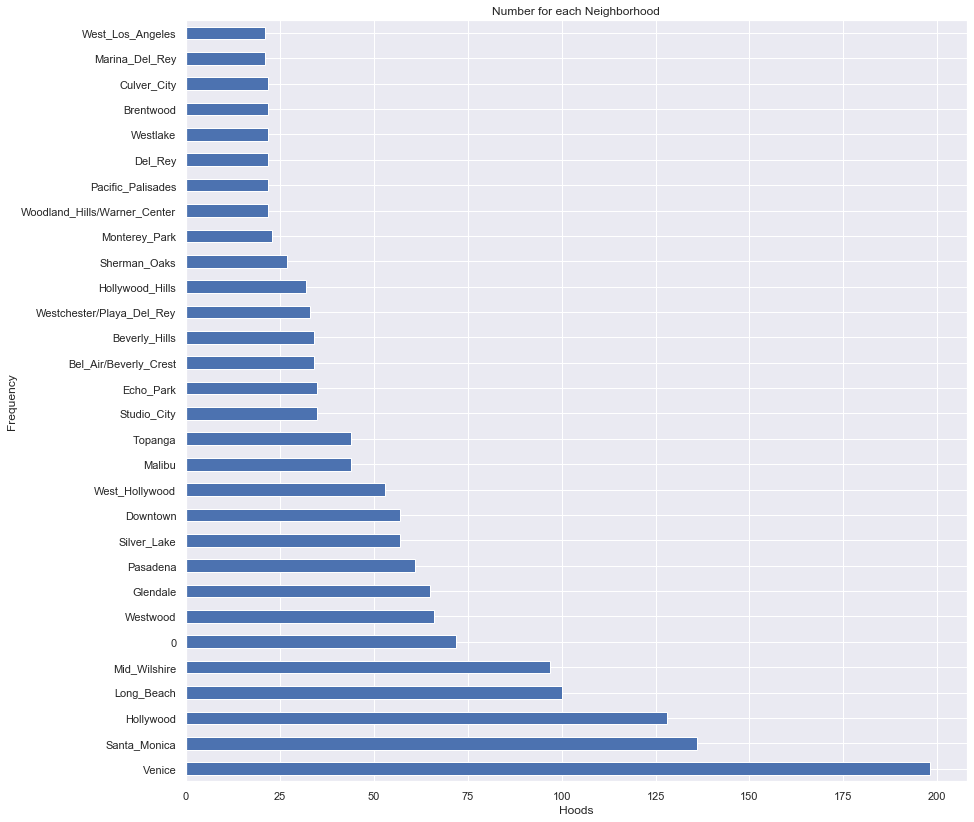

In [321]:
#look at neighborhood counts per neighborhood for too low predictions - 
#high end neighborhood outliers are not in the top 30 - not enough data on these places
ax = too_low_predictions['neighborhood'].value_counts().head(30).plot(kind='barh',
                                    figsize=(14,14),
                                    title="Number for each Neighborhood")
ax.set_xlabel("Hoods")
ax.set_ylabel("Frequency")
plt.show()

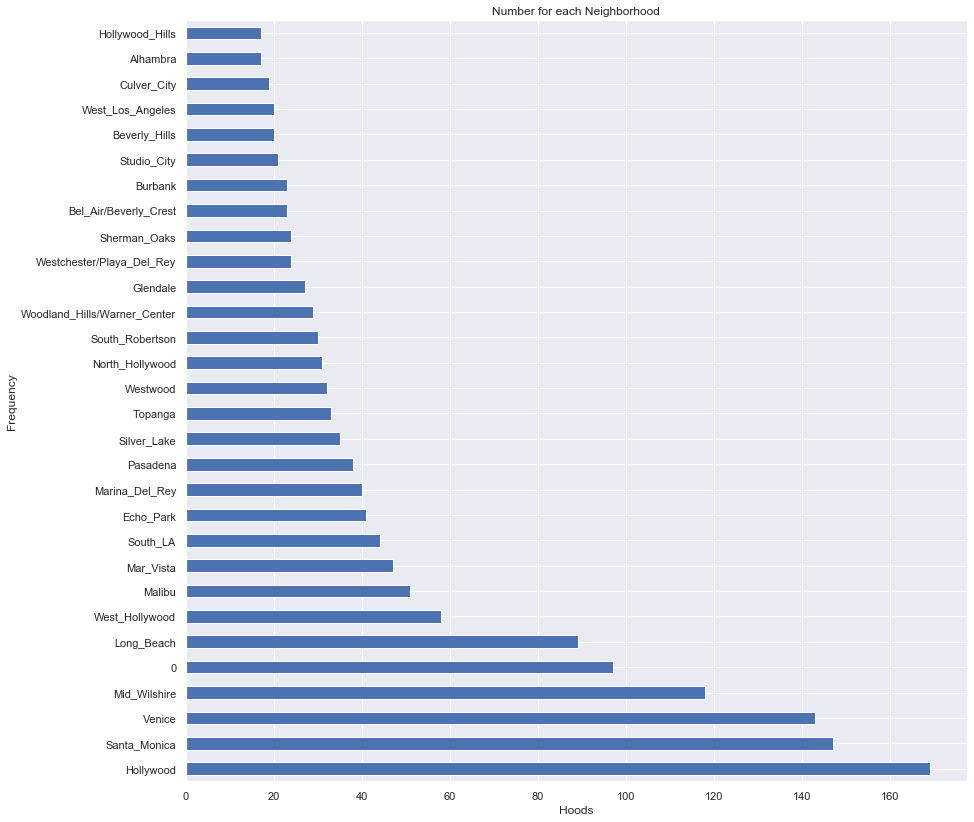

In [323]:
#look at neighborhood counts per neighborhood for too high predictions - 
#high end neighborhood outliers are not in the top 30 - not enough data on these places
ax = too_high_predictions['neighborhood'].value_counts().head(30).plot(kind='barh',
                                    figsize=(14,14),
                                    title="Number for each Neighborhood")
ax.set_xlabel("Hoods")
ax.set_ylabel("Frequency")
plt.show()

### 3.8 Look at Outliers from too_high_predictions

In [296]:
#Look at Outliers from too_high_predictions
#these seem to accomodate a lot of people

too_high_predictions.sort_values(by = ['price_minus_xgb_preds'], ascending=True).head(10)

,price,reviews_per_month,accommodates,bedrooms,bathrooms,beds,availability_365,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,property_type,latitude,longitude,neighborhood,neigh_br_competition,dishwasher,yard,patio,check_in_self,parking,pool,long_term,baby,children,family,check_in_24hrs,washer_dryer,air_con,heating,pets,lockbox,lat_lon,nearest_sales_price,arts_rec_count,arts_theater_count,comfort_vs_capacity,parks_one_mi,parks_four_mi,uni_two_mi,transport_airports_ten_mi,transport_freeway_two_mi,transport_metro_one_mi,transport_metro_two_mi,transport_convenience,rarity_per_pricey_hood,longitude_scaled_pos,rarity_property,nearest_sales_price_squared,amenities_convenience,xgb_preds,price_minus_xgb_preds
1517,150,2.11,13,5.0,3.5,6.0,328,10.0,10.0,10.0,9.0,9.0,House,34.15871,-118.47005,Encino,2,1,1,1,1,1,0,1,0,1,1,0,1,1,1,1,0,"(34.15871, -118.47005)",884250,2,0,49.102564,0,19,1,4,8,0,3,27,1.179000e+06,0.608838,2.601615e+06,781898062500,56,553.257874,-403.257874
3459,349,2.61,16,5.0,4.0,7.0,262,9.0,10.0,9.0,10.0,10.0,House,34.03713,-118.86809,Malibu,5,1,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,"(34.03713, -118.86809)",3200000,0,0,52.916667,0,4,0,0,0,0,0,0,3.733333e+06,2.675719,1.549563e+07,10240000000000,8,737.085083,-388.085083
7102,349,0.39,9,5.0,3.5,5.0,0,10.0,10.0,10.0,10.0,10.0,House,33.99626,-118.45420,Venice,5,0,1,1,0,1,0,0,0,0,1,1,1,0,1,1,0,"(33.99626, -118.4542)",1791500,6,6,49.222222,9,56,4,4,2,0,0,6,2.090083e+06,0.526534,4.824870e+06,3209472250000,740,713.159668,-364.159668
3456,349,1.23,12,4.0,3.5,5.0,343,9.0,9.0,9.0,10.0,8.0,House,34.03794,-118.64277,Malibu,9,1,1,1,0,1,0,0,0,0,1,1,1,1,1,1,0,"(34.03794, -118.64277)",3412500,0,0,38.241667,0,1,0,0,0,0,0,0,3.753750e+06,1.505712,1.230449e+07,11645156250000,2,676.551025,-327.551025
3465,374,1.69,24,8.0,4.0,14.0,240,10.0,10.0,10.0,10.0,10.0,House,34.04177,-118.90144,Malibu,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,"(34.04177, -118.90144)",3200000,0,0,97.611111,2,4,0,0,0,0,0,0,4.800000e+06,2.848894,1.711646e+07,10240000000000,124,692.789062,-318.789062
2791,425,1.32,8,4.0,3.5,4.0,364,10.0,9.0,10.0,9.0,9.0,House,34.10419,-118.37191,Laurel_Canyon,1,1,0,1,0,1,0,1,0,0,1,0,1,1,1,0,0,"(34.10419, -118.37191000000001)",2000000,10,6,38.387500,1,43,1,3,1,0,0,4,3.000000e+06,0.099231,5.198463e+06,4000000000000,220,736.883301,-311.883301
7095,389,0.49,8,4.0,3.5,5.0,111,10.0,10.0,10.0,10.0,10.0,House,33.98515,-118.46274,Venice,21,1,1,1,0,1,0,1,0,0,0,1,1,1,1,0,0,"(33.98515, -118.46274)",1791500,5,4,38.387500,12,47,2,4,1,0,0,5,1.872932e+06,0.570880,4.687163e+06,3209472250000,870,674.674561,-285.674561
8136,250,4.58,8,3.0,3.0,3.0,214,10.0,10.0,10.0,9.0,9.0,Villa,34.06010,-118.74384,0,0,1,1,1,1,1,0,0,0,0,0,0,1,1,1,0,0,"(34.0601, -118.74383999999999)",1500000,0,0,26.125000,1,4,0,0,0,0,0,0,3.000000e+06,2.030533,7.545799e+06,2250000000000,68,526.681580,-276.681580
338,500,0.08,16,7.0,10.0,8.0,0,10.0,10.0,10.0,10.0,10.0,Villa,34.11608,-118.42394,Bel_Air/Beverly_Crest,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,1,0,"(34.11608, -118.42393999999999)",2300000,8,3,165.875000,0,27,0,4,0,0,0,4,3.450000e+06,0.369405,6.599631e+06,5290000000000,98,776.537781,-276.537781
2416,245,1.86,6,3.0,3.0,3.0,365,10.0,10.0,10.0,10.0,9.0,Villa,34.10818,-118.34080,Hollywood,47,1,0,1,0,1,0,1,0,0,1,1,1,1,1,0,0,"(34.10818, -118.3408)",925000,10,7,26.250000,7,48,5,2,8,2,2,40,9.442708e+05,-0.062312,1.811632e+06,855625000000,866,518.967041,-273.967041


In [327]:
#Look at good predictions
#these seem to accomodate a normal amount of people, and have  a small interquartile range of price

airbnb_df['price_minus_xgb_preds_abs'] = abs(airbnb_df['price_minus_xgb_preds'])

In [331]:
good_predictions.sort_values(by = ['price_minus_xgb_preds_abs'], ascending=True).head(10)

,price,reviews_per_month,accommodates,bedrooms,bathrooms,beds,availability_365,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,property_type,latitude,longitude,neighborhood,neigh_br_competition,dishwasher,yard,patio,check_in_self,parking,pool,long_term,baby,children,family,check_in_24hrs,washer_dryer,air_con,heating,pets,lockbox,lat_lon,nearest_sales_price,arts_rec_count,arts_theater_count,comfort_vs_capacity,parks_one_mi,parks_four_mi,uni_two_mi,transport_airports_ten_mi,transport_freeway_two_mi,transport_metro_one_mi,transport_metro_two_mi,transport_convenience,rarity_per_pricey_hood,longitude_scaled_pos,rarity_property,nearest_sales_price_squared,amenities_convenience,xgb_preds,price_minus_xgb_preds,price_minus_xgb_preds_abs
5248,170,4.20,2,1.0,1.0,1.0,117,10.0,10.0,10.0,10.0,9.0,Guesthouse,34.00662,-118.48534,Santa_Monica,262,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,"(34.00662, -118.48534)",1300000,5,5,6.000000,9,48,4,3,3,0,0,6,1.304943e+06,0.688233,3.499646e+06,1690000000000,716,169.996048,0.003952,0.003952
7265,115,0.34,2,1.0,1.0,2.0,342,10.0,9.0,10.0,10.0,10.0,Apartment,34.09281,-118.34580,West_Hollywood,82,0,1,0,1,1,0,1,0,0,0,0,1,1,1,0,1,"(34.09281, -118.3458)",925000,11,7,6.000000,5,43,7,3,3,1,2,26,9.361446e+05,-0.036349,1.827522e+06,855625000000,643,115.005951,-0.005951,0.005951
1435,125,4.77,3,1.0,1.0,1.0,266,10.0,10.0,10.0,10.0,10.0,Guesthouse,33.92321,-118.41118,El_Segundo,22,0,0,0,1,1,0,1,0,0,1,1,1,0,1,0,0,"(33.92321, -118.41118)",1850000,2,4,5.833333,10,48,0,6,1,0,3,22,1.930435e+06,0.303147,4.341256e+06,3422500000000,720,124.993126,0.006874,0.006874
3132,149,2.34,5,2.0,1.0,3.0,166,10.0,10.0,10.0,10.0,10.0,Bungalow,33.81948,-118.11085,Long_Beach,127,1,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,"(33.81948, -118.11085)",667500,4,0,10.533333,3,71,2,3,8,0,0,11,6.727148e+05,-1.256361,5.015939e+05,445556250000,358,148.988358,0.011642,0.011642
2619,90,12.77,4,1.0,1.0,3.0,298,10.0,9.0,10.0,9.0,9.0,Apartment,33.94785,-118.34903,Inglewood,35,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,"(33.94785, -118.34903)",485000,5,3,5.750000,8,60,4,7,4,1,3,36,4.984722e+05,-0.019576,9.739777e+05,235225000000,764,90.013084,-0.013084,0.013084
5261,150,0.59,3,1.0,1.0,1.0,43,10.0,10.0,10.0,10.0,10.0,Apartment,34.01028,-118.49361,Santa_Monica,262,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,"(34.01028, -118.49361)",1300000,5,5,5.833333,10,46,4,3,3,0,0,6,1.304943e+06,0.731177,3.555473e+06,1690000000000,772,149.978485,0.021515,0.021515
2178,121,0.00,4,1.0,1.0,1.0,345,0.0,0.0,0.0,0.0,0.0,Apartment,34.10164,-118.34395,Hollywood,176,0,0,0,0,1,0,1,0,0,0,0,1,1,1,0,0,"(34.10164, -118.34395)",925000,10,7,5.750000,8,41,5,2,6,1,2,28,9.302260e+05,-0.045955,1.812718e+06,855625000000,789,121.024696,-0.024696,0.024696
5960,95,5.93,2,1.0,1.0,1.0,129,10.0,10.0,10.0,10.0,10.0,Guesthouse,34.10816,-118.17770,South_Pasadena,13,0,1,1,1,1,1,0,0,0,0,0,0,1,1,0,1,"(34.10816, -118.1777)",730000,8,7,6.000000,8,73,2,1,8,0,3,24,7.821429e+05,-0.909233,8.484031e+05,532900000000,706,94.973122,0.026878,0.026878
7818,105,3.21,6,2.0,1.0,2.0,112,10.0,10.0,10.0,10.0,10.0,House,33.98320,-118.05257,Whittier,6,0,1,0,1,1,0,1,1,0,1,0,1,1,1,0,0,"(33.9832, -118.05256999999999)",447500,1,0,10.500000,7,53,2,1,4,0,0,5,5.114286e+05,-1.558988,2.612812e+05,200256250000,550,105.042900,-0.042900,0.042900
1826,90,6.37,2,1.0,1.0,1.0,39,10.0,10.0,10.0,10.0,10.0,Guesthouse,33.92305,-118.37891,Hawthorne,19,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,"(33.92305, -118.37891)",550000,1,1,6.000000,3,60,1,7,7,3,6,74,5.775000e+05,0.135580,1.202069e+06,302500000000,522,89.952667,0.047333,0.047333


In [305]:
good_predictions.describe()

,price,reviews_per_month,accommodates,bedrooms,bathrooms,beds,availability_365,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,latitude,longitude,neigh_br_competition,dishwasher,yard,patio,check_in_self,parking,pool,long_term,baby,children,family,check_in_24hrs,washer_dryer,air_con,heating,pets,lockbox,nearest_sales_price,arts_rec_count,arts_theater_count,comfort_vs_capacity,parks_one_mi,parks_four_mi,uni_two_mi,transport_airports_ten_mi,transport_freeway_two_mi,transport_metro_one_mi,transport_metro_two_mi,transport_convenience,rarity_per_pricey_hood,longitude_scaled_pos,rarity_property,nearest_sales_price_squared,amenities_convenience,xgb_preds,price_minus_xgb_preds
count,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4.116000e+03,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4.116000e+03,4116.000000,4.116000e+03,4.116000e+03,4116.000000,4116.000000,4116.000000
mean,143.232021,2.897835,3.681730,1.183916,1.207119,1.868562,169.229592,9.341837,9.229106,9.351312,9.263848,9.139942,34.039866,-118.318236,64.538873,0.336978,0.443392,0.511905,0.608115,0.941934,0.005831,0.461856,0.051749,0.090865,0.328717,0.131195,0.657434,0.822400,0.961370,0.255831,0.250729,1.070315e+06,6.241011,4.322643,8.368828,4.729592,51.981050,4.095967,3.001458,6.010690,0.627551,2.064869,25.235180,1.154339e+06,-0.179481,2.285063e+06,1.934059e+12,542.012877,152.128784,-8.896760
std,74.769191,2.325795,2.101615,0.949487,0.499497,1.297337,119.119636,2.404635,2.394757,2.402207,2.393057,2.390615,0.136169,0.150102,69.717679,0.472735,0.496846,0.499919,0.488231,0.233897,0.076147,0.498603,0.221547,0.287452,0.469804,0.337655,0.474625,0.382222,0.192734,0.436380,0.433485,8.880746e+05,4.012705,3.271049,6.872629,3.246983,18.119963,4.036742,1.713501,5.874581,1.223508,2.971950,29.010445,9.597771e+05,0.779428,2.713447e+06,7.320758e+12,334.951027,72.861664,15.745659
min,49.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.338830,-118.807390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.338530e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.568984e+05,-3.627687,-4.582117e+05,1.114578e+11,0.000000,74.884560,-35.918976
25%,99.000000,1.000000,2.000000,1.000000,1.000000,1.000000,63.000000,10.000000,10.000000,10.000000,10.000000,9.000000,33.994595,-118.427345,13.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,6.300000e+05,3.000000,1.000000,5.700000,2.000000,43.000000,1.000000,1.000000,2.000000,0.000000,0.000000,6.000000,6.918113e+05,-0.625818,9.687044e+05,3.969000e+11,312.000000,109.002083,-22.022583
50%,123.000000,2.510000,3.000000,1.000000,1.000000,2.000000,153.000000,10.000000,10.000000,10.000000,10.000000,10.000000,34.061135,-118.337285,36.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,9.070000e+05,6.000000,4.000000,6.000000,4.000000,53.000000,3.000000,3.000000,5.000000,0.000000,1.000000,13.000000,9.321705e+05,-0.080564,1.713109e+06,8.226490e+11,470.500000,128.567848,-9.804962
75%,157.000000,4.242500,4.000000,2.000000,1.000000,2.000000,288.000000,10.000000,10.000000,10.000000,10.000000,10.000000,34.115970,-118.232280,84.750000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0000

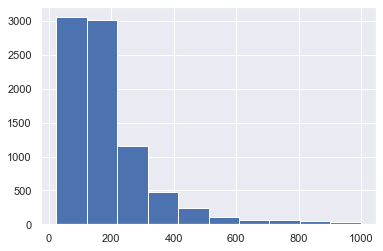

In [252]:
airbnb_df["price"].hist(bins=10)

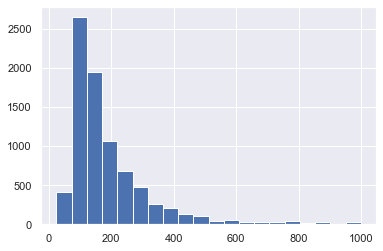

In [253]:
airbnb_df["price"].hist(bins=20)

### 3.9 Look at how the number of bedrooms effects the price

In [254]:
#make masks for bedroom ranges the backyard houses could have

mask_1br = airbnb_df["bedrooms"]==1.0
mask_2br = airbnb_df["bedrooms"]==2.0
mask_3br = airbnb_df["bedrooms"]==3.0
mask_4br = airbnb_df["bedrooms"]==4.0

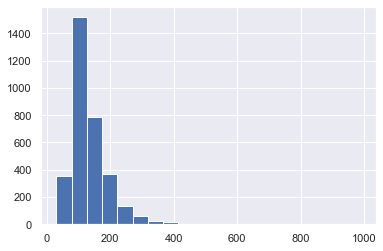

In [255]:
# 1 br price histogram
airbnb_df[mask_1br]["price"].hist(bins=20)

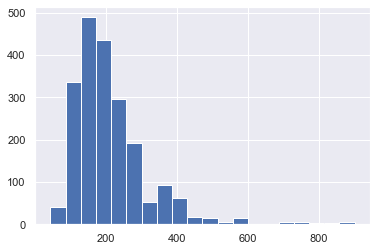

In [256]:
# 2 br price histogram
airbnb_df[mask_2br]["price"].hist(bins=20)

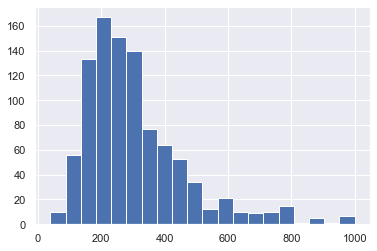

In [257]:
# 3 br price histogram
airbnb_df[mask_3br]["price"].hist(bins=20)

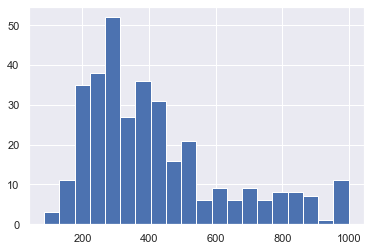

In [258]:
# 4 br price histogram
airbnb_df[mask_4br]["price"].hist(bins=20)

In [259]:
# mean price per bedroom 
bedroom_airbnb_df = airbnb_df.groupby('bedrooms').mean()

,price,reviews_per_month,accommodates,bathrooms,beds,availability_365,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,latitude,longitude,neigh_br_competition,dishwasher,yard,patio,check_in_self,parking,pool,long_term,baby,children,family,check_in_24hrs,washer_dryer,air_con,heating,pets,lockbox,nearest_sales_price,arts_rec_count,arts_theater_count,comfort_vs_capacity,parks_one_mi,parks_four_mi,uni_two_mi,transport_airports_ten_mi,transport_freeway_two_mi,transport_metro_one_mi,transport_metro_two_mi,transport_convenience,rarity_per_pricey_hood,longitude_scaled_pos,rarity_property,nearest_sales_price_squared,amenities_convenience
bedrooms,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,111.915182,3.099957,2.496793,1.001426,1.204562,165.839629,9.491091,9.380613,9.498218,9.426230,9.271561,34.053011,-118.338750,42.966500,0.181753,0.409123,0.449038,0.573058,0.911618,0.004989,0.374911,0.032787,0.050606,0.243051,0.120456,0.509622,0.803279,0.947969,0.243051,0.235210,1.125617e+06,6.766215,4.859587,3.463963,4.941554,51.800428,4.553100,3.037063,6.464718,0.733428,2.312901,27.683535,1.209924e+06,-0.072955,2.480257e+06,2.079961e+12,575.437634
1.0,134.079927,2.657032,2.867602,1.031574,1.399939,177.228188,9.259915,9.153447,9.262355,9.196766,9.051861,34.047016,-118.346035,93.654973,0.299268,0.417328,0.510067,0.584808,0.943868,0.009152,0.480781,0.049420,0.074131,0.309335,0.138194,0.653447,0.802929,0.963392,0.279439,0.261135,1.213498e+06,6.379195,4.496644,6.011359,4.727578,50.292556,4.110433,3.017694,5.770897,0.597315,1.943563,24.157718,1.270291e+06,-0.035127,2.761506e+06,2.609487e+12,536.650397
2.0,212.118783,2.171791,4.985514,1.547079,2.539353,179.500724,8.922743,8.786577,8.929503,8.870594,8.681796,34.030094,-118.331714,61.388218,0.573153,0.394978,0.562530,0.556736,0.958957,0.009657,0.478513,0.066152,0.119266,0.389184,0.138580,0.873008,0.809754,0.963303,0.290681,0.224046,1.193445e+06,6.475616,4.448093,12.515668,4.954611,50.559150,4.169000,3.112023,5.388218,0.560599,1.774022,22.849831,1.288777e+06,-0.109493,2.623694e+06,2.470915e+12,551.524867
3.0,308.280738,1.957715,7.134221,2.193648,3.879098,184.933402,9.005123,8.830943,9.013320,8.939549,8.763320,34.029924,-118.323060,21.354508,0.680328,0.548156,0.606557,0.602459,0.954918,0.005123,0.495902,0.093238,0.210041,0.439549,0.142418,0.938525,0.844262,0.959016,0.279713,0.192623,1.196937e+06,5.056352,3.385246,22.094990,4.287910,46.995902,3.347336,2.968238,4.428279,0.379098,1.428279,18.258197,1.361440e+06,-0.154428,2.723210e+06,2.845727e+12,456.562500
4.0,420.181818,1.908592,9.404692,2.919355,5.093842,193.076246,8.706745,8.498534,8.692082,8.624633,8.439883,34.040247,-118.320992,6.958944,0.721408,0.627566,0.659824,0.580645,0.953079,0.020528,0.504399,0.117302,0.222874,0.425220,0.117302,0.950147,0.885630,0.947214,0.243402,0.175953,1.140294e+06,4.768328,3.181818,35.146487,3.739003,44.395894,3.243402,2.882698,4.480938,0.322581,1.337243,17.117302,1.412732e+06,-0.165166,2.689183e+06,2.285759e+12,403.231672
5.0,540.000000,1.899322,11.805085,3.572034,6.610169,216.779661,8.779661,8.584746,8.788136,8.754237,8.525424,34.063029,-118.343730,2.830508,0.762712,0.694915,0.694915,0.533898,0.974576,0.000000,0.516949,0.118644,0.262712,0.415254,0.161017,0.983051,0.881356,0.966102,0.288136,0.152542,1.454176e+06,4.440678,2.669492,50.795974,3.169492,37.610169,2.474576,2.601695,4.000000,0.228814,1.000000,13.889831,1.895566e+06,-0.047099,3.698121e+06,4.500136e+12,334.771186
6.0,618.272727,1.664091,14.045455,4.727273,8.590909,211.954545,9.909091,9.681818,9.954545,9.772727,9.590909,34.129686,-118.296848,1.454545,0.772727,0.681818,0.772727,0.500000,1.000000,0.000000,0.454545,0.181818,0.181818,0.318182,0.090909,1.000000,1.000000,1.000000,0.136364,0.318182,1.566841e+06,5.636364,3.409091,73.796677,2.909091,40.545455,4.363636,2.045455,4.409091,0.545455,1.636364,20.090909,2.304747e+06,-0.290538,4.180517e+06,5.900466e+12,398.181818
7.0,520.818182,1.871818,14.545455,

In [ ]:
#save average values per number of bedrooms
bedroom_airbnb_df_pivot = bedroom_airbnb_df.iloc[1:4, :]
bedroom_airbnb_df_pivot.to_csv("bedroom_airbnb_df_pivot.csv")

In [351]:
bedroom_airbnb_df_pivot.columns

Index(['reviews_per_month', 'accommodates', 'bathrooms', 'beds',
       'availability_365', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'latitude',
       'longitude', 'neigh_br_competition', 'dishwasher', 'yard', 'patio',
       'check_in_self', 'parking', 'pool', 'long_term', 'baby', 'children',
       'family', 'check_in_24hrs', 'washer_dryer', 'air_con', 'heating',
       'pets', 'lockbox'],
      dtype='object')

### Look at price in relation to rarity feature

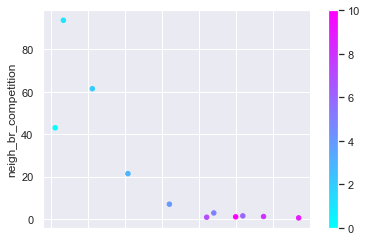

In [275]:
bedroom_airbnb_df.plot.scatter("price", "neigh_br_competition", c=bedroom_airbnb_df.index, colormap='cool')
plt.savefig("scater_price_competition_bedrooms.png")